# Hotel Booking Demand - Modeling

## Data loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('../data/processed/hotel_booking_clean.csv')

print("Dataset shape:", df.shape)
df.head()

Dataset shape: (87370, 30)


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,C,3,No Deposit,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,C,4,No Deposit,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,C,0,No Deposit,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,A,0,No Deposit,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,A,0,No Deposit,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87370 entries, 0 to 87369
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           87370 non-null  object 
 1   is_canceled                     87370 non-null  int64  
 2   lead_time                       87370 non-null  int64  
 3   arrival_date_year               87370 non-null  int64  
 4   arrival_date_month              87370 non-null  object 
 5   arrival_date_week_number        87370 non-null  int64  
 6   arrival_date_day_of_month       87370 non-null  int64  
 7   stays_in_weekend_nights         87370 non-null  int64  
 8   stays_in_week_nights            87370 non-null  int64  
 9   adults                          87370 non-null  int64  
 10  children                        87370 non-null  float64
 11  babies                          87370 non-null  int64  
 12  meal                            

## Feature Engineering

### Stay Length (Continuous and Categorical)

Cancellation behavior varies significantly with stay length, but in a non-linear way:  

- Short stays (1–7 nights): relatively low risk (~27%).  
- Medium stays (8–14 nights): moderate risk (~33%).  
- **Mid-long stays (15–30 nights):** the riskiest group, with **cancellation rates exceeding 50%**.  
- Very long stays (>30 nights): cancellations drop again (~17%), likely due to committed corporate or long-term bookings.  

This pattern indicates that stay length is an important feature, but its effect is not monotonic.  

- For **tree-based models** (Random Forest, XGBoost, LightGBM):  
  - The raw `total_stay` feature is sufficient, as trees can split around the risky ranges.  
- For **linear models** (Logistic Regression):  
  - Binned categories (short, medium, mid-long, long) are more effective for capturing the non-linear risk profile.  

**Decision:** Keep `total_stay` for all models, and also use categorical bins for linear models.


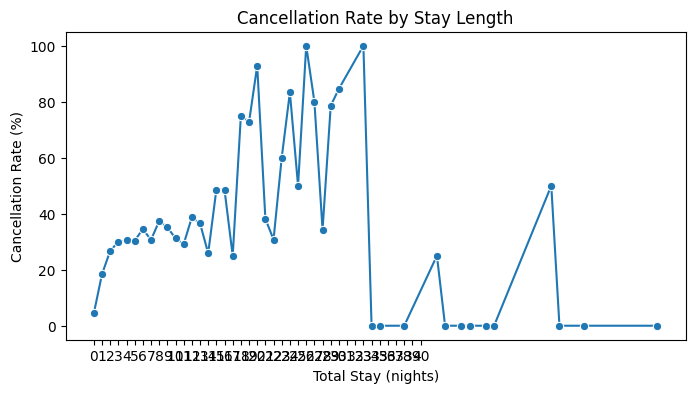

In [3]:
df["total_stay"] = df["stays_in_weekend_nights"] + df["stays_in_week_nights"]
stay_cancel_rate = (
    df.groupby("total_stay")["is_canceled"].mean().mul(100).reset_index()
)

# Plot
plt.figure(figsize=(8,4))
sns.lineplot(data=stay_cancel_rate, x="total_stay", y="is_canceled", marker="o")
plt.title("Cancellation Rate by Stay Length")
plt.xlabel("Total Stay (nights)")
plt.ylabel("Cancellation Rate (%)")
plt.xticks(range(0, min(df["total_stay"].max(), 40)+1))  # cap x-axis at 40 nights for readability
plt.show()


/tmp/ipykernel_8687/1018409193.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cancel_by_cat = df.groupby("stay_category")["is_canceled"].mean().mul(100).reset_index()


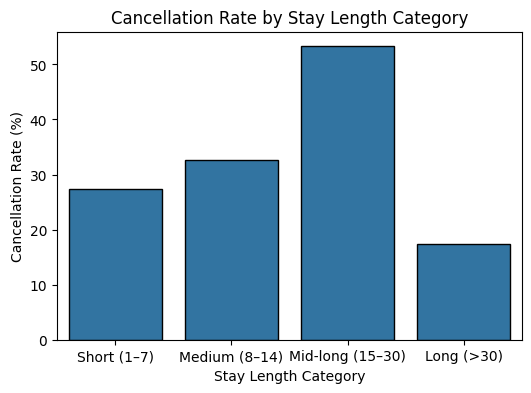

In [4]:
bins = [0, 7, 14, 30, df["total_stay"].max()]  
labels = ["Short (1–7)", "Medium (8–14)", "Mid-long (15–30)", "Long (>30)"]

df["stay_category"] = pd.cut(df["total_stay"], bins=bins, labels=labels, right=True)

cancel_by_cat = df.groupby("stay_category")["is_canceled"].mean().mul(100).reset_index()

plt.figure(figsize=(6,4))
sns.barplot(data=cancel_by_cat, x="stay_category", y="is_canceled", edgecolor="black")
plt.ylabel("Cancellation Rate (%)")
plt.xlabel("Stay Length Category")
plt.title("Cancellation Rate by Stay Length Category")
plt.show()

### Previous Cancellation Rate

Only a small fraction of customers (~2%) have a history of cancellations.  
However, this group shows a **much higher cancellation rate (~68%)** compared to those with no prior cancellations (~27%).  
Even though the feature is sparse, it provides a **strong signal** when present.

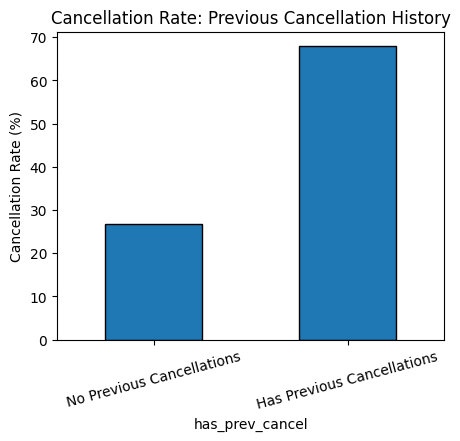

has_prev_cancel
0    98.07142
1     1.92858
Name: proportion, dtype: float64


In [5]:
df["has_prev_cancel"] = (df["previous_cancellations"] > 0).astype(int)

cancel_by_prev = df.groupby("has_prev_cancel")["is_canceled"].mean().mul(100)

ax = cancel_by_prev.plot(kind="bar", edgecolor="black", figsize=(5,4))
ax.set_ylabel("Cancellation Rate (%)")
ax.set_title("Cancellation Rate: Previous Cancellation History")
ax.set_xticklabels(["No Previous Cancellations","Has Previous Cancellations"], rotation=15)
plt.show()

print(df["has_prev_cancel"].value_counts(normalize=True).mul(100))


### Previous Successful Bookings

Customers with prior successful stays are **much less likely to cancel**.  
Their cancellation rate is only ~5%, compared to ~28% for customers with no prior successful bookings.  
This feature provides a **strong loyalty signal** that helps distinguish reliable repeat guests from new or uncertain ones.


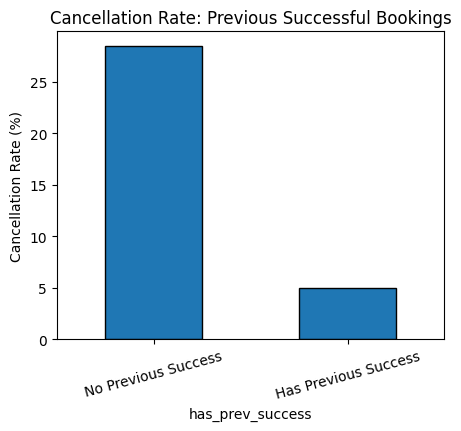

has_prev_success
0    95.942543
1     4.057457
Name: proportion, dtype: float64


In [6]:
df["has_prev_success"] = (df["previous_bookings_not_canceled"] > 0).astype(int)

cancel_by_prev_success = df.groupby("has_prev_success")["is_canceled"].mean().mul(100)

ax = cancel_by_prev_success.plot(kind="bar", edgecolor="black", figsize=(5,4))
ax.set_ylabel("Cancellation Rate (%)")
ax.set_title("Cancellation Rate: Previous Successful Bookings")
ax.set_xticklabels(["No Previous Success","Has Previous Success"], rotation=15)
plt.show()

print(df["has_prev_success"].value_counts(normalize=True).mul(100))


### Direct vs. Indirect Bookings  

Indirect bookings (~85% of total) have a much higher cancellation rate (~30%) compared to direct bookings (~15%).  

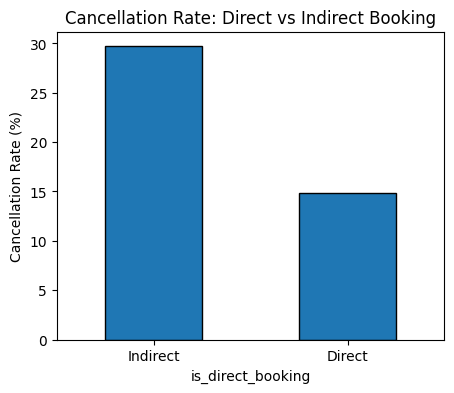

In [7]:
df["is_direct_booking"] = (df["distribution_channel"] == "Direct").astype(int)

cancel_by_channel = df.groupby("is_direct_booking")["is_canceled"].mean().mul(100)

ax = cancel_by_channel.plot(kind="bar", edgecolor="black", figsize=(5,4))
ax.set_ylabel("Cancellation Rate (%)")
ax.set_title("Cancellation Rate: Direct vs Indirect Booking")
ax.set_xticklabels(["Indirect","Direct"], rotation=0)
plt.show()


### Dropped Features  

The following engineered features were tested but not retained for modeling:  

- **is_weekend_arrival:** Cancellation rates are nearly identical for weekday vs weekend arrivals.  
- **is_midlong_stay:** Mid-long stays (15–30 nights) showed higher cancellation, but they represent only ~0.4% of bookings → too rare to provide value.  
- **is_high_adr:** High ADR bookings have slightly higher cancellations, but the difference is weak and the raw ADR feature is sufficient.  
- **room_changed:** Strongly associated with non-cancellation, but this is **data leakage** (only known at check-in). Excluded from all models.  

These were dropped to avoid unnecessary noise or leakage in the final dataset.  

## First Round Training

We will train and compare four models: **Logistic Regression, Random Forest, XGBoost, and LightGBM**.  
These cover both a linear baseline (Logistic Regression) and powerful tree-based ensembles (Random Forest, XGBoost, LightGBM).  

- **Decision Tree** and **Gradient Boosting** are excluded, as Random Forest and XGBoost typically outperform them.  
- **KNN**, **SVM**, and similar algorithms are not included, since they scale poorly with large, high-dimensional categorical data.  


### Data Preprocessing for lienar and tree models

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

target = "is_canceled"
drop_cols = ["is_canceled", "reservation_status", "reservation_status_date", "assigned_room_type"]

y = df[target]
X_base = df.drop(columns=drop_cols)

numeric_features = [
    "lead_time", "total_stay", "adr",
    "adults", "children", "babies",
    "total_of_special_requests", "days_in_waiting_list",
    "has_prev_cancel", "has_prev_success", "is_direct_booking"
]


categorical_features = [
    "hotel", "arrival_date_year", "arrival_date_month", "arrival_date_week_number",
    "arrival_date_day_of_month", "meal", "country", "market_segment",
    "distribution_channel", "is_repeated_guest", "reserved_room_type",
    "booking_changes", "deposit_type", "customer_type",
    "stay_category", "required_car_parking_spaces"
]

In [ ]:
# Logistic Regression preprocessing

scaler = StandardScaler()
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

X_num_scaled = pd.DataFrame(
    scaler.fit_transform(X_base[numeric_features]),
    columns=numeric_features,
    index=X_base.index
)

X_cat_encoded = pd.DataFrame(
    encoder.fit_transform(X_base[categorical_features]),
    columns=encoder.get_feature_names_out(categorical_features),
    index=X_base.index
)

X_linear = pd.concat([X_num_scaled, X_cat_encoded], axis=1)


In [ ]:
# Tree Models preprocessing

X_tree = X_base.copy()

for col in categorical_features:
    le = LabelEncoder()
    X_tree[col] = le.fit_transform(X_tree[col].astype(str))

In [11]:
print("X_linear shape:", X_linear.shape)
print("X_tree shape:", X_tree.shape)
print("y shape:", y.shape)

X_linear shape: (87370, 358)
X_tree shape: (87370, 31)
y shape: (87370,)


### Training Linear Model

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_linear, y, test_size=0.2, random_state=42, stratify=y
)

lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)
y_proba_lr = lr.predict_proba(X_test)

print("Accuracy (Logistic Regression):", round(accuracy_score(y_test, y_pred_lr)*100, 2), "%")
print("\nClassification Report (Logistic Regression):\n")
print(classification_report(y_test, y_pred_lr))

Accuracy (Logistic Regression): 79.76 %

Classification Report (Logistic Regression):

              precision    recall  f1-score   support

           0       0.82      0.92      0.87     12670
           1       0.69      0.48      0.57      4804

    accuracy                           0.80     17474
   macro avg       0.76      0.70      0.72     17474
weighted avg       0.79      0.80      0.79     17474



/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Training Tree models

In [13]:
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(
    X_tree, y, test_size=0.2, random_state=42, stratify=y
)

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)

print("Accuracy (Random Forest):", round(accuracy_score(y_test, y_pred_rf)*100, 2), "%")
print("\nClassification Report (Random Forest):\n")
print(classification_report(y_test, y_pred_rf))


Accuracy (Random Forest): 84.11 %

Classification Report (Random Forest):

              precision    recall  f1-score   support

           0       0.87      0.92      0.89     12670
           1       0.76      0.62      0.68      4804

    accuracy                           0.84     17474
   macro avg       0.81      0.77      0.79     17474
weighted avg       0.84      0.84      0.84     17474



In [14]:
from xgboost import XGBClassifier

X_train, X_test, y_train, y_test = train_test_split(
    X_tree, y, test_size=0.2, random_state=42, stratify=y
)

xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)


print("Accuracy (XGBoost):", round(accuracy_score(y_test, y_pred_xgb)*100, 2), "%")
print("\nClassification Report (XGBoost):\n")
print(classification_report(y_test, y_pred_xgb))

Accuracy (XGBoost): 83.91 %

Classification Report (XGBoost):

              precision    recall  f1-score   support

           0       0.87      0.92      0.89     12670
           1       0.74      0.64      0.69      4804

    accuracy                           0.84     17474
   macro avg       0.81      0.78      0.79     17474
weighted avg       0.83      0.84      0.84     17474



In [15]:
import lightgbm as lgb

X_train, X_test, y_train, y_test = train_test_split(
    X_tree, y, test_size=0.2, random_state=42, stratify=y
)

lgbm = lgb.LGBMClassifier(random_state=42)
lgbm.fit(X_train, y_train)

y_pred_lgbm = lgbm.predict(X_test)
y_proba_lgbm = lgbm.predict_proba(X_test)

print("Accuracy (LightGBM):", round(accuracy_score(y_test, y_pred_lgbm)*100, 2), "%")
print("\nClassification Report (LightGBM):\n")
print(classification_report(y_test, y_pred_lgbm))

[LightGBM] [Info] Number of positive: 19217, number of negative: 50679
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015015 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1054
[LightGBM] [Info] Number of data points in the train set: 69896, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.274937 -> initscore=-0.969716
[LightGBM] [Info] Start training from score -0.969716
Accuracy (LightGBM): 83.5 %

Classification Report (LightGBM):

              precision    recall  f1-score   support

           0       0.86      0.92      0.89     12670
           1       0.74      0.62      0.67      4804

    accuracy                           0.83     17474
   macro avg       0.80      0.77      0.78     17474
weighted avg       0.83      0.83      0.83     17474



### Compare results

Model Accuracies:
Logistic Regression: 0.7976 (79.76%)
Random Forest: 0.8411 (84.11%)
XGBoost: 0.8391 (83.91%)
LightGBM: 0.8350 (83.50%)


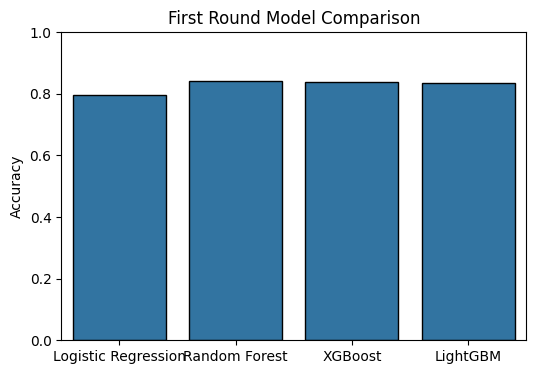

In [16]:
from sklearn.metrics import accuracy_score

results = {}

lr_acc = accuracy_score(y_test, y_pred_lr)
results["Logistic Regression"] = lr_acc
rf_acc = accuracy_score(y_test, y_pred_rf)
results["Random Forest"] = rf_acc
xgb_acc = accuracy_score(y_test, y_pred_xgb)
results["XGBoost"] = xgb_acc
lgbm_acc = accuracy_score(y_test, y_pred_lgbm)
results["LightGBM"] = lgbm_acc

print("Model Accuracies:")
for model, acc in results.items():
    print(f"{model}: {acc:.4f} ({acc*100:.2f}%)")

# Plot comparison
plt.figure(figsize=(6,4))
sns.barplot(x=list(results.keys()), y=list(results.values()), edgecolor="black")
plt.ylabel("Accuracy")
plt.title("First Round Model Comparison")
plt.ylim(0,1)
plt.show()


In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

metrics = {}

def evaluate_model(name, y_true, y_pred, y_proba):
    metrics[name] = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred),
        "ROC-AUC": roc_auc_score(y_true, y_proba[:,1])  # probability for class 1
    }

evaluate_model("Logistic Regression", y_test, y_pred_lr, y_proba_lr)
evaluate_model("Random Forest", y_test, y_pred_rf, y_proba_rf)
evaluate_model("XGBoost", y_test, y_pred_xgb, y_proba_xgb)
evaluate_model("LightGBM", y_test, y_pred_lgbm, y_proba_lgbm)

metrics_df = pd.DataFrame(metrics).T
metrics_df = metrics_df.round(4)
display(metrics_df)


,Accuracy,Precision,Recall,F1 Score,ROC-AUC
Logistic Regression,0.7976,0.6897,0.4798,0.5659,0.8425
Random Forest,0.8411,0.7576,0.6205,0.6822,0.8935
XGBoost,0.8391,0.7405,0.6384,0.6857,0.8993
LightGBM,0.8350,0.7394,0.6172,0.6728,0.8964


### Conclusion of first round

In the first round, we evaluated four candidate models — Logistic Regression, Random Forest, XGBoost, and LightGBM — on the cleaned and engineered dataset.

- Logistic Regression achieved ~80% accuracy, serving as a strong linear baseline.

Random Forest, XGBoost, and LightGBM all achieved accuracies in the 84% range, significantly outperforming the linear baseline.

- Differences among the three tree-based models were minimal (within ~0.2%), indicating they all capture the non-linear structure of the data effectively.

To balance **performance, diversity, and interpretability**, we will move forward with **Random Forest** – robust, interpretable, and less sensitive to tuning.

These two models provide complementary strengths (bagging vs. boosting), ensuring that the next round of hyperparameter tuning and interpretation is both rigorous and insightful.

##

## Hyperparameter Tuning

In this stage, we fine-tune Random Forest to check whether performance can be improved beyond the first-round baseline.

We use RandomizedSearchCV with a compact parameter grid and 3-fold stratified cross-validation:

- Instead of an exhaustive Grid Search, which is computationally expensive, we sample from a limited set of plausible parameter values.

- The search covers key Random Forest parameters such as the number of trees (n_estimators), tree depth (max_depth), feature subsampling (max_features), and minimum split/leaf sizes.

- This lightweight approach is sufficient to test whether tuning leads to meaningful gains without excessive runtime.

In [20]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from scipy.stats import randint, uniform

preprocessor = "passthrough"

rf_base = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", rf_base)
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_dist = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [10, 15, 20],
    "model__min_samples_split": [2, 5],
    "model__min_samples_leaf": [1, 2],
    "model__max_features": ["sqrt", 0.4]
}

search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    n_jobs=-1,
    random_state=42,
    verbose=1
)
search.fit(X_train, y_train)

mean_score = search.best_score_
std_score  = np.std(search.cv_results_["mean_test_score"])
print("Best RF CV accuracy:", f"{mean_score:.4f} ± {std_score:.4f}")
print("Best params:", search.best_params_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


Best RF CV accuracy: 0.8363 ± 0.0078
Best params: {'model__n_estimators': 100, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_features': 0.4, 'model__max_depth': 20}


In [21]:
best_rf = search.best_estimator_
best_rf.fit(X_train, y_train)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, 1]

print("Test Accuracy:", f"{accuracy_score(y_test, y_pred):.4f}")
print("Precision:", f"{precision_score(y_test, y_pred):.4f}")
print("Recall:", f"{recall_score(y_test, y_pred):.4f}")
print("F1:", f"{f1_score(y_test, y_pred):.4f}")
print("ROC-AUC:", f"{roc_auc_score(y_test, y_proba):.4f}")

Test Accuracy: 0.8398
Precision: 0.7455
Recall: 0.6334
F1: 0.6849
ROC-AUC: 0.8978


## Feature Importance

In [24]:
importances = best_rf.named_steps["model"].feature_importances_
feature_names = X_train.columns

feat_imp = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

feat_imp.head(10)


,Feature,Importance
1,lead_time,0.152249
12,country,0.108747
23,adr,0.090101
25,total_of_special_requests,0.085139
13,market_segment,0.077276
4,arrival_date_week_number,0.057780
5,arrival_date_day_of_month,0.054402
24,required_car_parking_spaces,0.045103
2,arrival_date_year,0.037364
26,total_stay,0.031300


## Conclusion: Fine-Tuning and Feature Importance  

Fine-tuning improved results only marginally (≤0.5%), showing diminishing returns beyond the first round.  

Key drivers of cancellations:  
- **Lead time** (longer bookings → higher risk)  
- **Country of origin** (regional differences)  
- **ADR** (unusual prices signal unreliable bookings)  

Other factors like **special requests**, **market segment**, and **arrival timing** also matter.  